In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [2]:
ds = xr.open_dataset('/Users/zcaspar/codes/mit4320/lf_autocov.nc').rename({'u_bar_u_bar':'u'})

In [3]:
filter_cutoff = [0.2,0.5,0.9]
ds = ds.assign_coords({'filt':filter_cutoff})

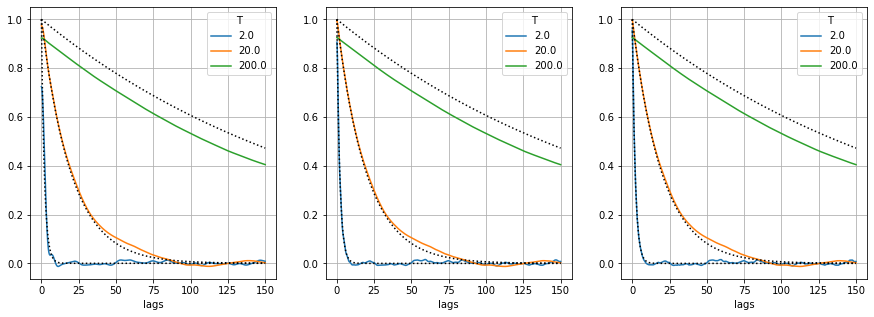

In [4]:
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds.filt.values): 
    ds.u.mean('draw').sel(filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s cpd'%str(f))
    (np.exp(-ds.lags/ds.T)).plot(ax=ax[i],hue='T',c='k',linestyle='dotted',add_legend=False)
    #ax[i].axhline(1,c='k',linestyle='--')
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_autocv_mean.png')

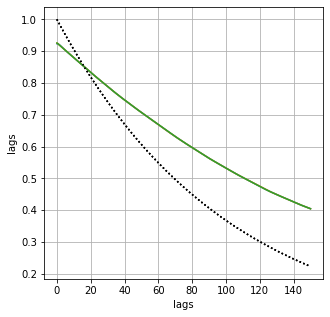

In [5]:
fig,ax = plt.subplots(figsize=(5,5))
for f in ds.filt.values:
    ds.u.mean('draw').sel(filt=f,T=200).plot(ax=ax)
    np.exp(-ds.lags/100).plot(ax=ax,c='k',linestyle='dotted')
    #np.exp(-ds.lags/Tbar_fit[200].sel(filt=f,param='Tbar').params).plot(ax=ax,c='k')
ax.grid()

In [6]:
def zero_crossing(data,T,filt):
    try : 
        out = data.where(np.sign(data).diff('lags')!=0,drop=True).sel(filt=filt,T=T).dropna('lags').isel(lags=0)
    except : 
        out = data.isel(lags=-1)
    return out

In [7]:
ds_mean = ds.u.mean('draw')

In [13]:
ds_mean

<xarray.DataArray 'u' (filt: 3, T: 3, lags: 3601)>
array([[[0.72422678, 0.72406039, 0.72362538, ..., 0.00846843,
         0.00842423, 0.0083814 ],
        [0.97401886, 0.97401477, 0.9739573 , ..., 0.00260035,
         0.00257527, 0.00255027],
        [0.92340941, 0.92341333, 0.92341165, ..., 0.4048188 ,
         0.4047322 , 0.40464553]],

       [[0.90648049, 0.90584524, 0.90396845, ..., 0.00795791,
         0.00796158, 0.00796161],
        [0.99290074, 0.99284388, 0.99263031, ..., 0.00264987,
         0.00262514, 0.00260006],
        [0.92526415, 0.92526325, 0.92524637, ..., 0.40478844,
         0.40470167, 0.40461498]],

       [[0.95512508, 0.95378648, 0.94980662, ..., 0.00773269,
         0.00770941, 0.00769244],
        [0.99683424, 0.99670721, 0.99628418, ..., 0.00271009,
         0.0026881 , 0.00266472],
        [0.92562809, 0.92562052, 0.92558305, ..., 0.40478685,
         0.40469988, 0.40461284]]])
Coordinates:
  * T        (T) float64 2.0 20.0 200.0
  * filt     (filt) float64 0.2 0.5 0.9
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 149.9 150.0 150.0

In [10]:
def wrap(data,T,filt):
    zero = zero_crossing(data,T,filt)
    #imin = np.min(0,zero.lags.values)
    #print(zero.lags.values,imin)
#    if zero == 0data.ise:
#        Tbar = xr.DataArray(0,coords={'T':T,'filt':filt}).rename('u') #
#    else:
    _ = data.sel(T=T,filt=filt).sel(lags = slice(0,zero.lags.values))
    Tbar = _.integrate('lags')
    return Tbar#.drop(['T','filt'])

In [14]:
wrap(ds_mean,200,0.2)

<xarray.DataArray 'u' ()>
array(94.64629962)
Coordinates:
    T        float64 200.0
    filt     float64 0.2

In [15]:
Tbar = {}
for t in ds_mean['T'].values:
    Tbar[t] = xr.concat([wrap(ds_mean,t,f) for f in ds_mean['filt'].values],dim='filt'
                       ).assign_coords({'filt':ds_mean['filt'].values})

In [16]:
true_Tbar = ds_mean['T']


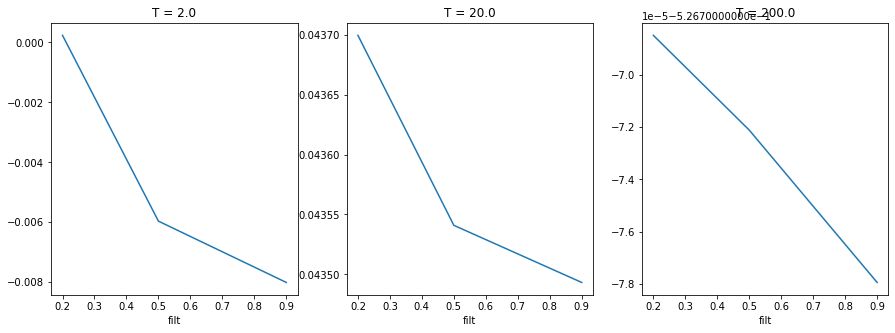

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i,t in enumerate(ds_mean['T'].values):
    ((Tbar[t]-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)).plot(ax=ax[i])

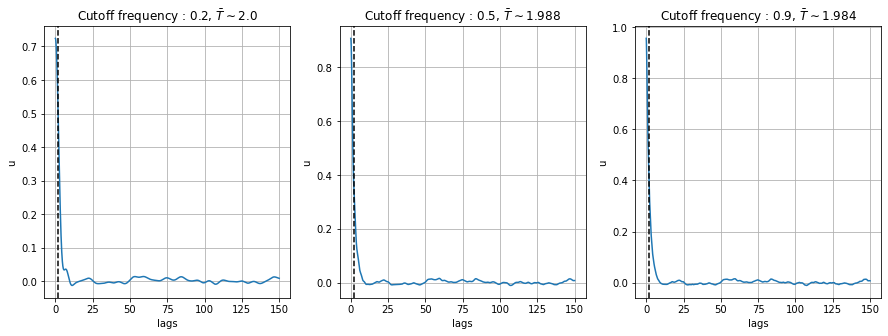

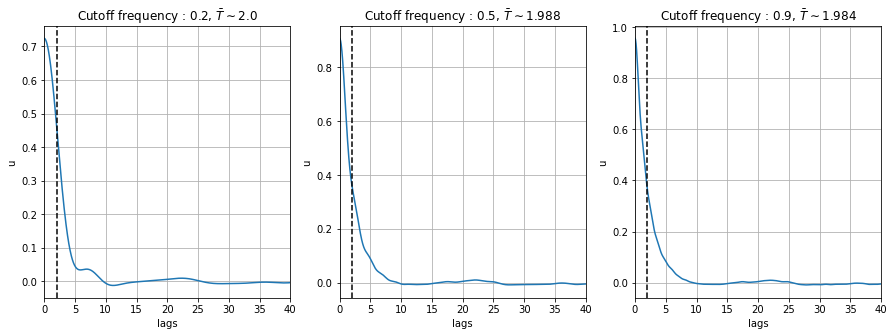

In [18]:
t = 2
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--')
    
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--');ax[i].set_xlim(0,40)

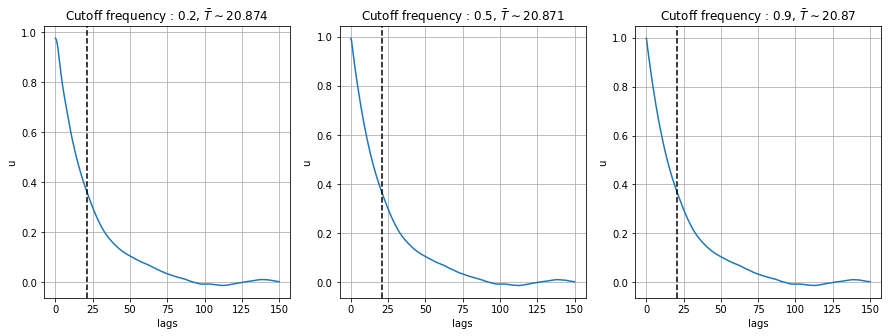

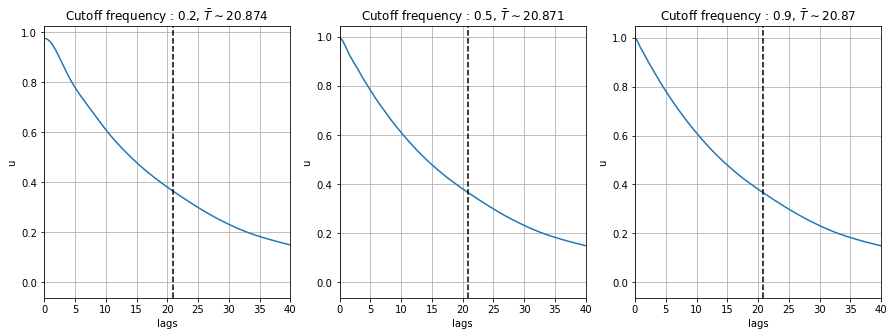

In [19]:
t = 20
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--')
    
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--');ax[i].set_xlim(0,40)

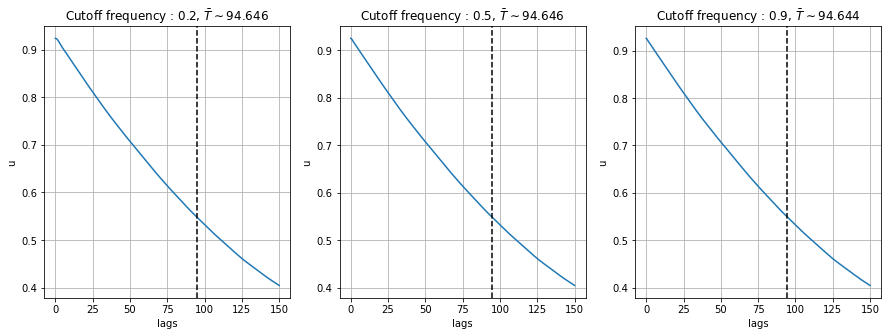

In [20]:
t = 200
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--')
    


In [46]:
def yfit(tau,Tbar,V):
    return V*np.exp(-tau/Tbar)

def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['filt','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['filt','lags'],np.expand_dims(yfit,axis=0)),
                     'error' : (['filt','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'filt':np.array([y['filt'].values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [47]:
from inspect import signature
import scipy


# Parameters
myfunc = yfit #function to use for the fit
bounds = ((0,0),(1000,2)) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'
tau = ds_mean.lags.values


In [48]:
import scipy.optimize

In [49]:
Tbar_fit = {}
for t in ds_mean['T'].values:
    Tbar_fit[t] = xr.concat([fit(tau,ds_mean.sel(filt=f,T=t),myfunc,bounds,norm=False
                             ) for f in ds_mean['filt'].values],dim='filt'
                        ).assign_coords({'filt':ds_mean['filt'].values})

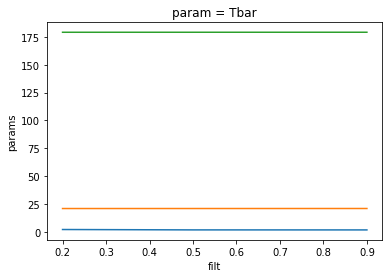

In [50]:
for t in ds_mean['T'].values:
    Tbar_fit[t].sel(param = 'Tbar').params.plot()

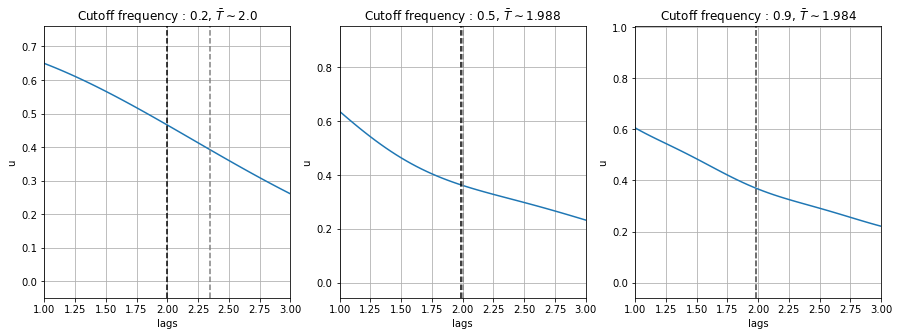

In [51]:
t = 2
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    Tb_fit = Tbar_fit[t].sel(filt=f,param='Tbar').params.values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--');ax[i].set_xlim(1,3);
    ax[i].axvline(Tb_fit,c='grey',linestyle='--');

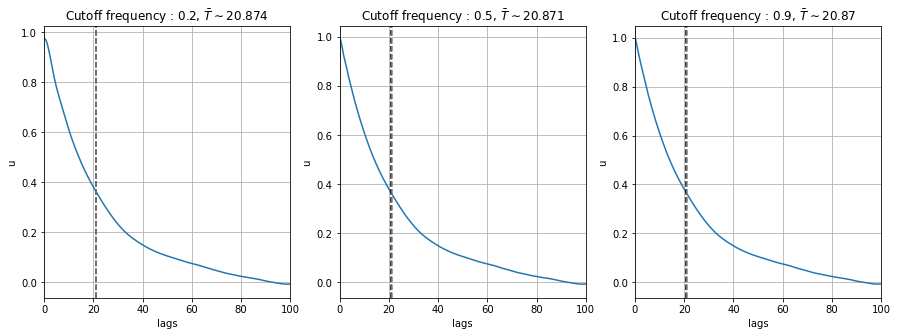

In [52]:
t = 20
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    Tb_fit = Tbar_fit[t].sel(filt=f,param='Tbar').params.values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--');ax[i].set_xlim(0,100);
    ax[i].axvline(Tb_fit,c='grey',linestyle='--');

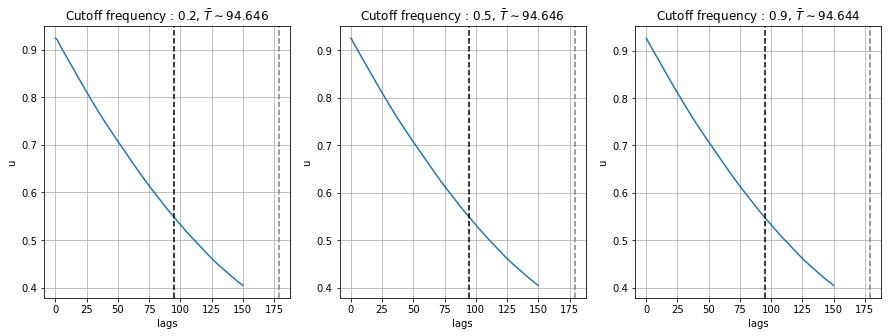

In [53]:
t = 200
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,f in enumerate(ds_mean.filt.values):
    #_ = ds_mean.sel(T=t,filt=f).sel(lags = slice(zero_cross.sel(filt=f).lags.values))
    #Tbar = _.integrate('lags')
    #print( Tbar.values)
    Tb = Tbar[t].sel(filt=f).values
    Tb_fit = Tbar_fit[t].sel(filt=f,param='Tbar').params.values
    ds_mean.sel(T=t,filt=f).plot(ax=ax[i],hue='T')
    ax[i].grid();ax[i].set_title('Cutoff frequency : %s'%str(f) +
                                 r', $\bar T \sim $%s'%str(np.around(Tb,decimals=3)))
    ax[i].axvline(Tb,c='k',linestyle='--');
    ax[i].axvline(Tb_fit,c='grey',linestyle='--');

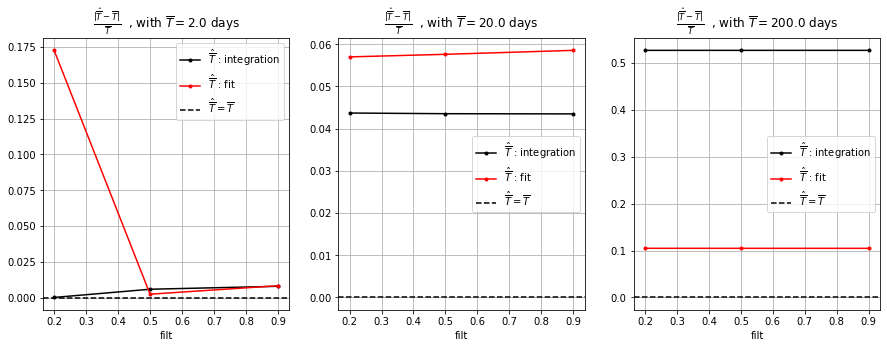

In [54]:
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for i,t in enumerate(ds_mean['T'].values):
    Tb = Tbar[t]#.values
    Tb_fit = Tbar_fit[t].sel(param='Tbar').params#.values
    (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
    ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
    (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
     ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
    ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
   # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
    ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
    ax[i].legend();
    
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_Tbar.png')


#### Impact of subsampling

In [32]:
Tbar_3h = {}
ds_mean_3h = ds_mean.isel(lags=slice(0,None,3))
for t in ds_mean['T'].values:
    Tbar_3h[t] = xr.concat([wrap(ds_mean_3h,t,f) for f in ds_mean_3h['filt'].values],dim='filt'
                       ).assign_coords({'filt':ds_mean_3h['filt'].values})

In [33]:
Tbar_6h = {}
ds_mean_6h = ds_mean.isel(lags=slice(0,None,6))
for t in ds_mean['T'].values:
    Tbar_6h[t] = xr.concat([wrap(ds_mean_6h,t,f) for f in ds_mean_6h['filt'].values],dim='filt'
                       ).assign_coords({'filt':ds_mean_6h['filt'].values})

In [34]:
Tbar_fit_3h = {}
tau = ds_mean_3h.lags.values
for t in ds_mean_3h['T'].values:
    Tbar_fit_3h[t] = xr.concat([fit(tau,ds_mean_3h.sel(filt=f,T=t),myfunc,bounds,norm=False
                             ) for f in ds_mean_3h['filt'].values],dim='filt'
                        ).assign_coords({'filt':ds_mean_3h['filt'].values})
    
Tbar_fit_6h = {}
tau = ds_mean_6h.lags.values
for t in ds_mean_3h['T'].values:
    Tbar_fit_6h[t] = xr.concat([fit(tau,ds_mean_6h.sel(filt=f,T=t),myfunc,bounds,norm=False
                             ) for f in ds_mean_6h['filt'].values],dim='filt'
                        ).assign_coords({'filt':ds_mean_6h['filt'].values})

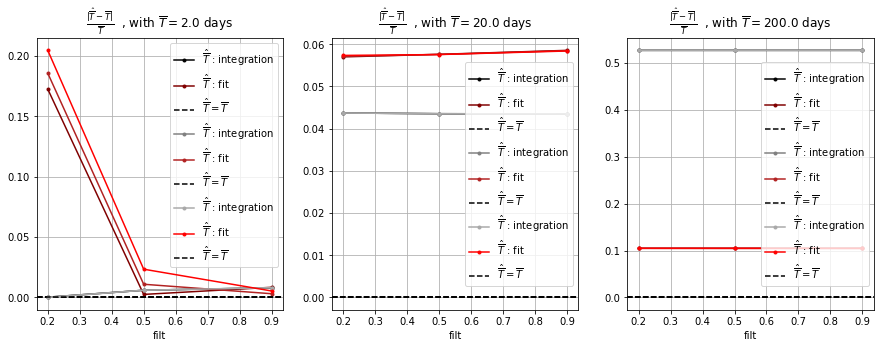

In [35]:
TB = [Tbar,Tbar_3h,Tbar_6h]
TB_fit = [Tbar_fit,Tbar_fit_3h,Tbar_fit_6h]
color_Tb = ['k','grey','darkgrey']
color_Tb_fit = ['maroon','firebrick','r']
fig,ax = plt.subplots(1,len(filter_cutoff),figsize=(5*len(filter_cutoff),5))
for j in range(len(TB)):
    for i,t in enumerate(ds_mean['T'].values):
        Tb = TB[j][t]#.values
        Tb_fit = TB_fit[j][t].sel(param='Tbar').params#.values
        (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
        ).plot(ax=ax[i],c = color_Tb[j],marker='.',label=r'$\hat{\overline{T}}$ : integration');
        (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
         ).plot(ax=ax[i],c = color_Tb_fit[j],marker='.',label=r'$\hat{\overline{T}}$ : fit');
        ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
       # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
        ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
        ax[i].legend();


fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_Tbar_subsampling.png')